In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from functools import partial
from scipy.optimize import bisect, brentq, newton
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

1. Исходные данные

In [2]:
# Фиксация генератора случайных чисел
random_seed = 1901
np.random.seed(random_seed)

# Значения предикторов для прогноза целевой переменной
# A_complex_max = [1800 + 1000j, 1500 + 1000j, 1800 + 1400j, 2000 + 1700j, 1500 + 1200j]
A_complex_max = [600 + 200j, 240 + 170j, 700 + 320j, 800 + 300j, 400 + 150j]

# Относительный размер тестовой выборки
test_size = 0.3

2. Загрузка датасетов

In [3]:
# Загрузка точных коэффициентов регрессии (для контроля обучения моделей)
z_complex_acc = pd.read_excel('C:\Datasets/dataset_z_complex_acc.xlsx').astype(complex)
z_complex_acc.T

,0,1,2,3,4
0,0.04+0.02j,0.035+0.015j,0.03+0.02j,0.020+0.012j,0.016+0.010j


In [4]:
# Загрузка датасета с данными из комплексных чисел
df_complex = pd.read_excel('C:\Datasets/dataset_complex_1.xlsx').astype(complex)
df_complex

,A_h_1,A_h_2,A_h_3,A_h_4,A_h_5,b_d
0,411.020052+154.132519j,166.187063+83.093532j,469.526303+208.678357j,695.399462+289.749776j,203.592542+101.796271j,40.365917+52.825804j
1,435.594381+163.347893j,193.461282+96.730641j,481.933944+214.192864j,654.298746+272.624477j,219.843382+109.921691j,45.433008+59.465012j
2,438.980812+164.617805j,230.392713+115.196356j,420.257051+186.780911j,680.376588+283.490245j,187.632928+93.816464j,34.716494+45.435122j
3,400.766964+150.287612j,210.601673+105.300837j,451.856218+200.824986j,645.277058+268.865441j,235.510716+117.755358j,47.275564+61.878001j
4,371.435720+139.288395j,205.100165+102.550082j,533.338487+237.039328j,576.467513+240.194797j,200.725943+100.362972j,44.702238+58.487099j
...,...,...,...,...,...,...
95,806.399265+302.399724j,342.300909+171.150455j,765.824582+340.366481j,1379.294027+574.705845j,441.442892+220.721446j,79.803011+104.515055j
96,866.137217+324.801456j,351.696868+175.848434j,946.282398+420.569955j,1222.122015+509.217506j,428.621144+214.310572j,69.781498+91.402536j
97,854.883004+320.581126j,400.840360+200.420180j,1058.115746+470.273665j,1152.113075+480.047115j,455.522800+227.761400j,65.811312+86.235099j
98,906.488103+339.933039j,448.367782+224.183891j,1031.825618+458.589164j,1409.386848+587.244520j,369.931218+184.965609j,78.622187+103.021358j


3. Попарные графики рассеяния модулей значений переменных датасета

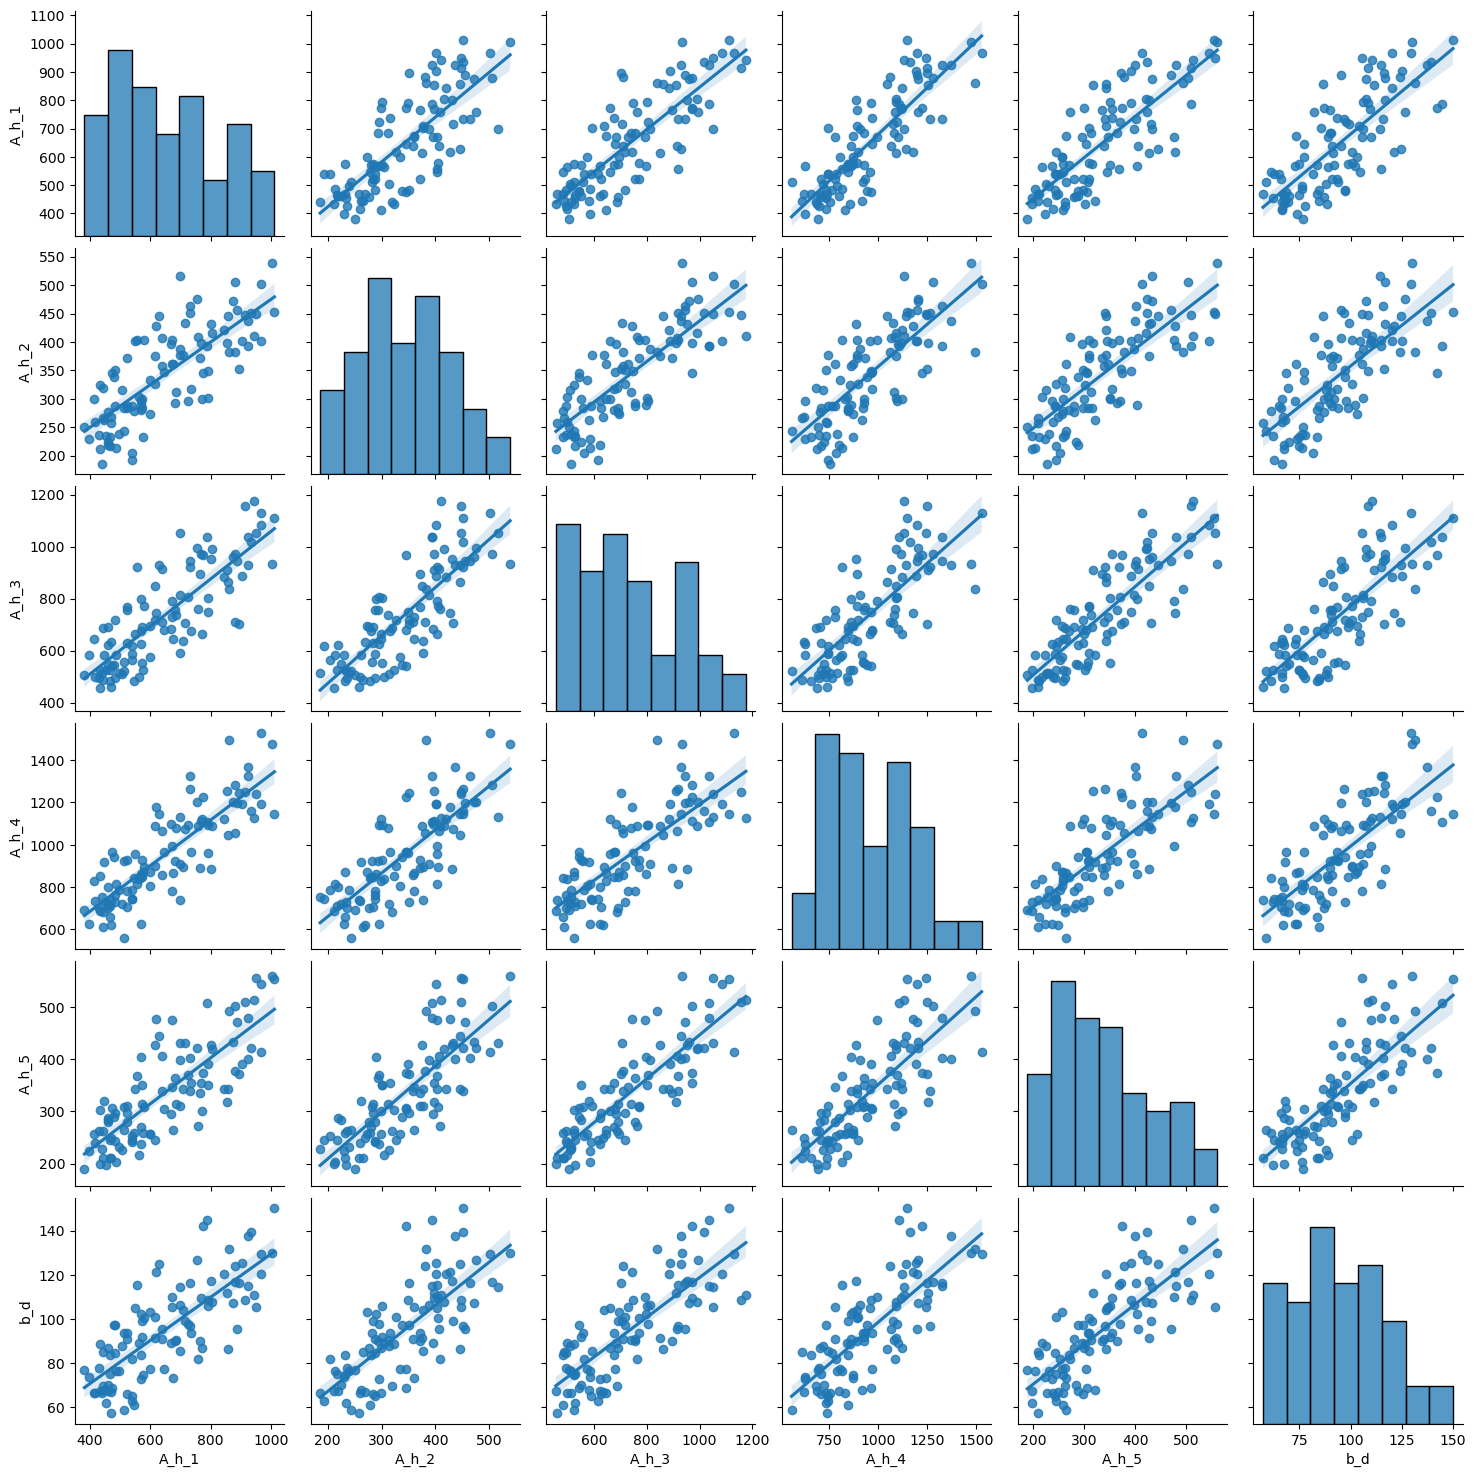

In [5]:
df_modul = df_complex.applymap(lambda x: abs(x))
sns.pairplot(df_modul, kind="reg")
plt.show()

4. Выделение комплексной матрицы признаков и комплексного вектора целевой переменной из датасета df_complex

In [6]:
A_complex = df_complex.iloc[:, :-1].values
b_complex = df_complex.iloc[:, -1].values
cond_A_complex = np.linalg.cond(A_complex.T @ A_complex)
det_A_complex = np.linalg.det(A_complex.T @ A_complex)

print(f'Число обусловленности матрицы A_complex: cond(A_complex) = {cond_A_complex.round(1)}')
print("Определитель матрицы A_complex:", det_A_complex)

Число обусловленности матрицы A_complex: cond(A_complex) = 1329.2
Определитель матрицы A_complex: (-1.7727183547229635e+30-3.1379959407429386e+30j)


5. Разбиение на обучающую и тестовые выборки

In [7]:
A_train_complex, A_test_complex, b_train_complex, b_test_complex = train_test_split(A_complex, 
                                                                                    b_complex,
                                                                                    test_size=test_size,
                                                                                    random_state=random_seed)

6. Формирование вещественной матрицы A_train признаков и вещественного вектора b_train целевой переменной

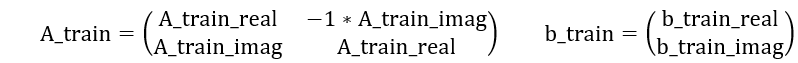


In [8]:
A_train_real = A_train_complex.real
A_train_imag = A_train_complex.imag
A_train_1 = pd.concat([pd.DataFrame(A_train_real), pd.DataFrame(A_train_imag)], axis=0)
A_train_2 = pd.concat([-1 * pd.DataFrame(A_train_imag), pd.DataFrame(A_train_real)], axis=0)
index_train = np.arange(A_train_1.shape[0])
A_train_1.index = index_train
A_train_2.index = index_train 
A_train = pd.merge(A_train_1, A_train_2, left_index=True, right_index=True)
A_train.columns = [f'A_{i+1}' for i in range(A_train.shape[1])]

In [9]:
b_train_real = b_train_complex.real
b_train_imag = b_train_complex.imag
b_train = pd.concat([pd.DataFrame(b_train_real), pd.DataFrame(b_train_imag)], axis=0)
b_train.index = index_train
b_train.columns = ['b']

7. Формирование вещественной матрицы A_test признаков и вещественного вектора b_test целевой переменной

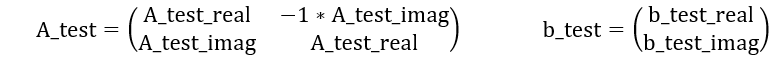

In [10]:
A_test_real = A_test_complex.real
A_test_imag = A_test_complex.imag
A_test_1 = pd.concat([pd.DataFrame(A_test_real), pd.DataFrame(A_test_imag)], axis=0)
A_test_2 = pd.concat([-1 * pd.DataFrame(A_test_imag), pd.DataFrame(A_test_real)], axis=0)
index_test = np.arange(A_test_1.shape[0])
A_test_1.index = index_test
A_test_2.index = index_test 
A_test = pd.merge(A_test_1, A_test_2, left_index=True, right_index=True)
A_test.columns = [f'A_{i+1}' for i in range(A_test.shape[1])]

In [11]:
b_test_real = b_test_complex.real
b_test_imag = b_test_complex.imag
b_test = pd.concat([pd.DataFrame(b_test_real), pd.DataFrame(b_test_imag)], axis=0)
b_test.index = index_test
b_test.columns = ['b']

8. Формирование вещественного вектора A_max для прогноза целевой переменной

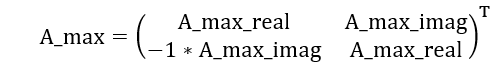

In [12]:
A_max_real = np.array(A_complex_max).real
A_max_imag = np.array(A_complex_max).imag
A_max_1 = pd.concat([pd.DataFrame(A_max_real), -1 * pd.DataFrame(A_max_imag)], axis=0)
A_max_2 = pd.concat([pd.DataFrame(A_max_imag), pd.DataFrame(A_max_real)], axis=0)
index_max = np.arange(A_max_1.shape[0])
A_max_1.index = index_max
A_max_2.index = index_max 
A_max = pd.merge(A_max_1, A_max_2, left_index=True, right_index=True)
A_max = A_max.T
A_max

,0,1,2,3,4,5,6,7,8,9
0_x,600.0,240.0,700.0,800.0,400.0,-200.0,-170.0,-320.0,-300.0,-150.0
0_y,200.0,170.0,320.0,300.0,150.0,600.0,240.0,700.0,800.0,400.0


9. Масштабирование признаков и вектора A_max

In [13]:
sc = MaxAbsScaler()    # MaxAbsScaler()    StandardScaler()

# Переход к привычным обозначениям X и y для признаков и целевых переменных
X_train_std = sc.fit_transform(A_train) 
X_test_std = sc.transform(A_test)
# X_train_std = A_train 
# X_test_std = A_test

y_train = b_train
y_test = b_test

In [14]:
A_max_std = sc.transform(A_max)
# A_max_std = A_max
pd.DataFrame(A_max_std).round(3)

,0,1,2,3,4,5,6,7,8,9
0,0.633,0.520,0.652,0.568,0.808,-0.211,-0.368,-0.298,-0.213,-0.303
1,0.211,0.368,0.298,0.213,0.303,0.633,0.520,0.652,0.568,0.808


10. Обучение моделей регрессоров на train-данных

In [15]:
metrics = {}

10.1 LinearRegression

In [16]:
lr = LinearRegression()
model_lr = lr.fit(X_train_std, y_train)

y_lr_pred = model_lr.predict(X_test_std)
y_lr_pred_train = model_lr.predict(X_train_std)

rmse_lr_train = np.sqrt(mean_squared_error(y_train, y_lr_pred_train)).round(3)
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_lr_pred)).round(3)
mae_lr_train = mean_absolute_error(y_train, y_lr_pred_train).round(3)
mae_lr_test = mean_absolute_error(y_test, y_lr_pred).round(3)
r2_lr_train = r2_score(y_train, y_lr_pred_train).round(3)
r2_lr_test = r2_score(y_test, y_lr_pred).round(3)

b_max_lr = model_lr.predict(A_max_std)[:].flatten()
b_max_lr_complex = complex(b_max_lr[0], b_max_lr[1])
b_max_lr_modul = np.abs(b_max_lr_complex)
b_max_lr_arg = np.angle(b_max_lr_complex) * 180 / np.pi
metrics['LinearRegr'] = (str(r2_lr_train), str(r2_lr_test), np.round(b_max_lr_complex, 1), str(b_max_lr_modul.round(1)), str(b_max_lr_arg.round(1)))

print(f'RMSE train: {rmse_lr_train}')
print(f'RMSE test:  {rmse_lr_test}')
print()
print(f'MAE train:  {mae_lr_train}')
print(f'MAE test:   {mae_lr_test}')
print()
print(f'R2 train:   {r2_lr_train}')
print(f'R2 test:    {r2_lr_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_lr_complex, 1)}')
print(f'b max_modul:   {b_max_lr_modul.round(1)}')
print()
print(f'Свободный член регрессии  a0 =  {model_lr.intercept_.round(3)}')
print('Масштабированные коэффициенты регрессии:')
pd.DataFrame({'z_real': model_lr.coef_.flatten()[:len(A_complex_max)], 'z_imag': model_lr.coef_.flatten()[len(A_complex_max):]}).T.round(1)

RMSE train: 8.436
RMSE test:  8.532

MAE train:  7.107
MAE test:   7.136

R2 train:   0.785
R2 test:    0.737

Прогноз целевой переменной:
b max_complex: (63.3+76.9j)
b max_modul:   99.6

Свободный член регрессии  a0 =  [9.567]
Масштабированные коэффициенты регрессии:


,0,1,2,3,4
z_real,16.8,5.3,29.0,22.9,30.1
z_imag,10.6,3.4,16.1,15.0,14.4


10.2 Ridge

In [17]:
rid = Ridge()
rid_parameters = {'alpha': np.logspace(-5, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_rid = GridSearchCV(estimator=rid,
                   param_grid=rid_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_rid.fit(X_train_std, y_train)

y_rid_pred = model_rid.predict(X_test_std)
y_rid_pred_train = model_rid.predict(X_train_std)

rmse_rid_train = np.sqrt(mean_squared_error(y_train, y_rid_pred_train)).round(3)
rmse_rid_test = np.sqrt(mean_squared_error(y_test, y_rid_pred)).round(3)
mae_rid_train = mean_absolute_error(y_train, y_rid_pred_train).round(3)
mae_rid_test = mean_absolute_error(y_test, y_rid_pred).round(3)
r2_rid_train = r2_score(y_train, y_rid_pred_train).round(3)
r2_rid_test = r2_score(y_test, y_rid_pred).round(3)

b_max_rid = model_rid.predict(A_max_std)[:].flatten()
b_max_rid_complex = complex(b_max_rid[0], b_max_rid[1])
b_max_rid_modul = np.abs(b_max_rid_complex)
b_max_rid_arg = np.angle(b_max_rid_complex) * 180 / np.pi
metrics['Ridge'] = (str(r2_rid_train), str(r2_rid_test), np.round(b_max_rid_complex, 1), str(b_max_rid_modul.round(1)), str(b_max_rid_arg.round(1)))

print(f'RMSE train: {rmse_rid_train}')
print(f'RMSE test:  {rmse_rid_test}')
print()
print(f'MAE train:  {mae_rid_train}')
print(f'MAE test:   {mae_rid_test}')
print()
print(f'R2 train:   {r2_rid_train}')
print(f'R2 test:    {r2_rid_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_rid_complex, 1)}')
print(f'b max_modul:   {b_max_rid_modul.round(1)}')
model_rid.best_params_

RMSE train: 8.516
RMSE test:  8.118

MAE train:  7.104
MAE test:   6.905

R2 train:   0.781
R2 test:    0.762

Прогноз целевой переменной:
b max_complex: (61+76.3j)
b max_modul:   97.6


{'alpha': 0.630957344480193, 'random_state': 1}

10.3 Lasso

In [18]:
lass = Lasso()
lass_parameters = {'alpha': np.logspace(-5, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_lass = GridSearchCV(estimator=lass,
                   param_grid=lass_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_lass.fit(X_train_std, y_train)

y_lass_pred = model_lass.predict(X_test_std)
y_lass_pred_train = model_lass.predict(X_train_std)

rmse_lass_train = np.sqrt(mean_squared_error(y_train, y_lass_pred_train)).round(3)
rmse_lass_test = np.sqrt(mean_squared_error(y_test, y_lass_pred)).round(3)
mae_lass_train = mean_absolute_error(y_train, y_lass_pred_train).round(3)
mae_lass_test = mean_absolute_error(y_test, y_lass_pred).round(3)
r2_lass_train = r2_score(y_train, y_lass_pred_train).round(3)
r2_lass_test = r2_score(y_test, y_lass_pred).round(3)

b_max_lass = model_lass.predict(A_max_std)[:].flatten()
b_max_lass_complex = complex(b_max_lass[0], b_max_lass[1])
b_max_lass_modul = np.abs(b_max_lass_complex)
b_max_lass_arg = np.angle(b_max_lass_complex) * 180 / np.pi
metrics['Lasso'] = (str(r2_lass_train), str(r2_lass_test), np.round(b_max_lass_complex, 1), str(b_max_lass_modul.round(1)), str(b_max_lass_arg.round(1)))

print(f'RMSE train: {rmse_lass_train}')
print(f'RMSE test:  {rmse_lass_test}')
print()
print(f'MAE train:  {mae_lass_train}')
print(f'MAE test:   {mae_lass_test}')
print()
print(f'R2 train:   {r2_lass_train}')
print(f'R2 test:    {r2_lass_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_lass_complex, 1)}')
print(f'b max_modul:   {b_max_lass_modul.round(1)}')
model_lass.best_params_

RMSE train: 8.451
RMSE test:  8.404

MAE train:  7.08
MAE test:   7.051

R2 train:   0.785
R2 test:    0.745

Прогноз целевой переменной:
b max_complex: (63.7+76.9j)
b max_modul:   99.9


{'alpha': 0.039810717055349734, 'random_state': 1}

10.4 ElasticNet

In [19]:
en = ElasticNet()
en_parameters = {'alpha': np.logspace(-5, 3, num=101),
                 'l1_ratio': (0.05, 0.1, 0.3, 0.5, 0.7, 0.9),
                 'random_state':[1, 7, 42, 100]
}
model_en = GridSearchCV(estimator=en,
                   param_grid=en_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_en.fit(X_train_std, y_train)

y_en_pred = model_en.predict(X_test_std)
y_en_pred_train = model_en.predict(X_train_std)

rmse_en_train = np.sqrt(mean_squared_error(y_train, y_en_pred_train)).round(3)
rmse_en_test = np.sqrt(mean_squared_error(y_test, y_en_pred)).round(3)
mae_en_train = mean_absolute_error(y_train, y_en_pred_train).round(3)
mae_en_test = mean_absolute_error(y_test, y_en_pred).round(3)
r2_en_train = r2_score(y_train, y_en_pred_train).round(3)
r2_en_test = r2_score(y_test, y_en_pred).round(3)

b_max_en = model_en.predict(A_max_std).flatten()
b_max_en_complex = complex(b_max_en[0], b_max_en[1])
b_max_en_modul = np.abs(b_max_en_complex)
b_max_en_arg = np.angle(b_max_en_complex) * 180 / np.pi
metrics['ElasticNet'] = (str(r2_en_train), str(r2_en_test), np.round(b_max_en_complex, 1), str(b_max_en_modul.round(1)), str(b_max_en_arg.round(1)))

print(f'RMSE train: {rmse_en_train}')
print(f'RMSE test:  {rmse_en_test}')
print()
print(f'MAE train:  {mae_en_train}')
print(f'MAE test:   {mae_en_test}')
print()
print(f'R2 train:   {r2_en_train}')
print(f'R2 test:    {r2_en_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_en_complex, 1)}')
print(f'b max_modul:   {b_max_en_modul.round(1)}')
model_en.best_params_

RMSE train: 8.556
RMSE test:  8.047

MAE train:  7.11
MAE test:   6.866

R2 train:   0.779
R2 test:    0.766

Прогноз целевой переменной:
b max_complex: (60.7+76.2j)
b max_modul:   97.4


{'alpha': 0.006309573444801936, 'l1_ratio': 0.05, 'random_state': 1}

10.5 TheilSenRegressor

In [20]:
tsr = TheilSenRegressor()
tsr_parameters = {'random_state':[1, 7, 42, 100]
}
model_tsr = GridSearchCV(estimator=tsr,
                   param_grid=tsr_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_tsr.fit(X_train_std, y_train)

y_tsr_pred = model_tsr.predict(X_test_std)
y_tsr_pred_train = model_tsr.predict(X_train_std)

rmse_tsr_train = np.sqrt(mean_squared_error(y_train, y_tsr_pred_train)).round(3)
rmse_tsr_test = np.sqrt(mean_squared_error(y_test, y_tsr_pred)).round(3)
mae_tsr_train = mean_absolute_error(y_train, y_tsr_pred_train).round(3)
mae_tsr_test = mean_absolute_error(y_test, y_tsr_pred).round(3)
r2_tsr_train = r2_score(y_train, y_tsr_pred_train).round(3)
r2_tsr_test = r2_score(y_test, y_tsr_pred).round(3)

b_max_tsr = model_tsr.predict(A_max_std).flatten()
b_max_tsr_complex = complex(b_max_tsr[0], b_max_tsr[1])
b_max_tsr_modul = np.abs(b_max_tsr_complex)
b_max_tsr_arg = np.angle(b_max_tsr_complex) * 180 / np.pi
metrics['TheilSenRegr'] = (str(r2_tsr_train), str(r2_tsr_test), np.round(b_max_tsr_complex, 1), str(b_max_tsr_modul.round(1)), str(b_max_tsr_arg.round(1)))

print(f'RMSE train: {rmse_tsr_train}')
print(f'RMSE test:  {rmse_tsr_test}')
print()
print(f'MAE train:  {mae_tsr_train}')
print(f'MAE test:   {mae_tsr_test}')
print()
print(f'R2 train:   {r2_tsr_train}')
print(f'R2 test:    {r2_tsr_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_tsr_complex, 1)}')
print(f'b max_modul:   {b_max_tsr_modul.round(1)}')
model_tsr.best_params_

RMSE train: 8.502
RMSE test:  8.139

MAE train:  7.106
MAE test:   6.982

R2 train:   0.782
R2 test:    0.761

Прогноз целевой переменной:
b max_complex: (60.5+75.4j)
b max_modul:   96.7


{'random_state': 100}

11. Средние значения метрик регрессоров и целевой переменной b

In [21]:
r2_train_values = [metrics[key][-5] for key in metrics]
r2_train_values = [float(value) for value in r2_train_values[:-1]]
r2_train_mean = round(sum(r2_train_values) / len(r2_train_values), 3)
r2_test_values = [metrics[key][-4] for key in metrics]
r2_test_values = [float(value) for value in r2_test_values[:-1]]
r2_test_mean = round(sum(r2_test_values) / len(r2_test_values), 3)

b_max_values = [metrics[key][-3] for key in metrics]
b_max_mean = sum(b_max_values) / len(b_max_values)
b_max_mean_complex = b_max_mean
b_max_mean_modul = np.abs(b_max_mean_complex)
b_max_mean_arg = np.angle(b_max_mean_complex) * 180 / np.pi
metrics['Mean'] = (str(r2_train_mean), str(r2_test_mean), np.round(b_max_mean_complex, 1), str(b_max_mean_modul.round(1)), str(b_max_mean_arg.round(1)))

print(f'Средние значения прогноза целевой переменной различными регрессорами:')
print(f'b_max_mean_complex: {np.round(b_max_mean_complex, 1)}')
print(f'b_max_mean_modul:   {b_max_mean_modul.round(1)}')

Средние значения прогноза целевой переменной различными регрессорами:
b_max_mean_complex: (61.8+76.3j)
b_max_mean_modul:   98.2


12. Обучение Feed Forward Neural Network

In [22]:
# Определение функции коэффициента детерминации R2
def r_squared(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (SS_res / SS_tot)


# Задание диапазона значений для числа слоев и числа нейронов
num_neurons_range = range(8, 25, 4)

# Задание диапазона значений для seed_value
seed_values = range(1900, 1911)

# Инициализация переменных для сохранения лучшей модели
best_r2 = -np.inf

# Цикл обучения моделей с разным числом нейронов на каждом слое
for num_neurons_1 in num_neurons_range:
    for num_neurons_2 in num_neurons_range:
        print(f'Number of neurons in Layer 1: {num_neurons_1}, Number of neurons in Layer 2: {num_neurons_2}')
        
        for seed_value in seed_values:
            
            # Установка seed_value для генератора случайных чисел
            random.seed(seed_value)
            np.random.seed(seed_value)
            tf.random.set_seed(seed_value)

            model = Sequential()
            model.add(Dense(num_neurons_1, activation='relu', input_shape=(X_train_std.shape[1],)))
            model.add(Dense(num_neurons_2, activation='relu'))
            model.add(Dense(1, activation='linear'))

            model.compile(optimizer='adam', loss='mean_squared_error')
            early_stop = EarlyStopping(monitor='val_loss', patience=10)
            history = model.fit(X_train_std, y_train, epochs=200, validation_split=0.2, callbacks=[early_stop], verbose=0)

            y_pred = model.predict(X_test_std)
            y_pred_train = model.predict(X_train_std)
            r2 = r_squared(np.ravel(y_test), np.ravel(y_pred))
            r2_train = r_squared(np.ravel(y_train), np.ravel(y_pred_train))

            print(f'r2 train = {r2_train.round(7)}')
            print(f'r2 test  = {r2.round(7)}')
            print()

            if r2 > best_r2:
                best_r2 = r2
                best_num_neurons_1 = num_neurons_1
                best_num_neurons_2 = num_neurons_2
                best_seed = seed_value
                best_model = model
                best_history = history

Number of neurons in Layer 1: 8, Number of neurons in Layer 2: 8
5/5 [==============================] - 0s 1ms/step
r2 train = 0.7667095
r2 test  = 0.7744403

5/5 [==============================] - 0s 2ms/step
r2 train = 0.7552451
r2 test  = 0.7705402

5/5 [==============================] - 0s 2ms/step
r2 train = 0.6774383
r2 test  = 0.7124439

5/5 [==============================] - 0s 2ms/step
r2 train = 0.7638039
r2 test  = 0.773654

5/5 [==============================] - 0s 2ms/step
r2 train = 0.6971498
r2 test  = 0.7217281

5/5 [==============================] - 0s 2ms/step
r2 train = 0.2861046
r2 test  = 0.3086789

5/5 [==============================] - 0s 2ms/step
r2 train = 0.761236
r2 test  = 0.7713716

5/5 [==============================] - 0s 2ms/step
r2 train = 0.1973439
r2 test  = 0.2033652

5/5 [==============================] - 0s 2ms/step
r2 train = 0.473725
r2 test  = 0.5012985

5/5 [==============================] - 0s 2ms/step
r2 train = 0.765566
r2 test  = 0.7714346


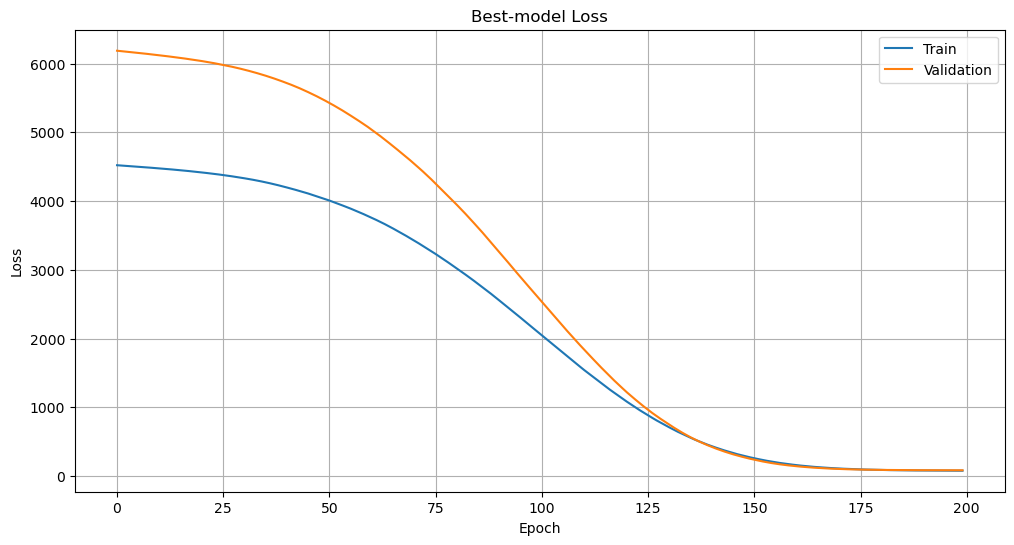

In [23]:
# Построение графиков функции потерь
plt.figure(figsize=(12, 6))
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Best-model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

In [24]:
print('R2_best:', best_r2.round(5))
print('Число нейронов на слое 1 для лучшей модели:', best_num_neurons_1)
print('Число нейронов на слое 2 для лучшей модели:', best_num_neurons_2)
print('Значение seed для best-модели:', best_seed)

R2_best: 0.77832
Число нейронов на слое 1 для лучшей модели: 12
Число нейронов на слое 2 для лучшей модели: 8
Значение seed для best-модели: 1904


In [25]:
y_NN_pred = best_model.predict(X_test_std)
y_NN_pred_train = best_model.predict(X_train_std)

rmse_NN_train = np.sqrt(mean_squared_error(y_train, y_NN_pred_train)).round(3)
rmse_NN_test = np.sqrt(mean_squared_error(y_test, y_NN_pred)).round(3)
mae_NN_train = mean_absolute_error(y_train, y_NN_pred_train).round(3)
mae_NN_test = mean_absolute_error(y_test, y_NN_pred).round(3)
r2_NN_train = r2_score(y_train, y_NN_pred_train).round(3)
r2_NN_test = r2_score(y_test, y_NN_pred).round(3)

b_max_NN = best_model.predict(A_max_std)[:].flatten()
b_max_NN_complex = complex(b_max_NN[0], b_max_NN[1])
b_max_NN_modul = np.abs(b_max_NN_complex)
b_max_NN_arg = np.angle(b_max_NN_complex) * 180 / np.pi
metrics['NeuralNet_best'] = (str(r2_NN_train), str(r2_NN_test), np.round(b_max_NN_complex, 1), str(b_max_NN_modul.round(1)), str(b_max_NN_arg.round(1)))

1/1 [==============================] - 0s 23ms/step


In [26]:
print(f'Метрики для best-модели:')
print(f'RMSE train: {rmse_NN_train}')
print(f'RMSE test:  {rmse_NN_test}')
print()
print(f'MAE train:  {mae_NN_train}')
print(f'MAE test:   {mae_NN_test}')
print()
print(f'R2 train:   {r2_score(y_train, y_NN_pred_train).round(6)}')
print(f'R2 test:    {r2_score(y_test, y_NN_pred).round(6)}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex_best:    {np.round(b_max_NN_complex, 1)}')
print(f'b max_modul_best:      {b_max_NN_modul.round(1)}')

Метрики для best-модели:
RMSE train: 8.899
RMSE test:  7.831

MAE train:  7.193
MAE test:   6.794

R2 train:   0.761142
R2 test:    0.778318

Прогноз целевой переменной:
b max_complex_best:    (57.8+74.7j)
b max_modul_best:      94.4


13. Условно точный прогноз целевой переменной b

In [29]:
b_max_acc_complex = np.dot(np.array(A_complex_max), np.array(z_complex_acc)).round(3)
b_max_acc_modul = abs(b_max_acc_complex).round(3)
b_max_acc_arg = np.angle(b_max_acc_complex) * 180 / np.pi
metrics['Accurate'] = ('', '', str(b_max_acc_complex[0].round(1)), str(b_max_acc_modul[0].round(1)), str(b_max_acc_arg[0].round(1)))

print(f'Условно точный прогноз целевой переменной по известным точным коэффициентам регрессии:')
print(f'b_max_acc_complex: {b_max_acc_complex[0]}')
print(f'b_max_acc_modul: {b_max_acc_modul[0]}')

Условно точный прогноз целевой переменной по известным точным коэффициентам регрессии:
b_max_acc_complex: (57.75+75.15j)
b_max_acc_modul: 94.777


14. Сводная таблица метрик и прогнозов моделей

In [30]:
df_metrics = pd.DataFrame(metrics)
df_metrics.index = ['R2 train', 'R2 test', 'b_max_complex', 'b_max_modul', 'b_max_arg, DEG']
df_metrics = df_metrics.astype(object)
df_metrics

,LinearRegr,Ridge,Lasso,ElasticNet,TheilSenRegr,Mean,NeuralNet_best,Accurate
R2 train,0.785,0.781,0.785,0.779,0.782,0.782,0.761,
R2 test,0.737,0.762,0.745,0.766,0.761,0.753,0.778,
b_max_complex,(63.3+76.9j),(61+76.3j),(63.7+76.9j),(60.7+76.2j),(60.5+75.4j),(61.8+76.3j),(57.8+74.7j),(57.8+75.2j)
b_max_modul,99.6,97.6,99.9,97.4,96.7,98.2,94.4,94.8
"b_max_arg, DEG",50.5,51.4,50.4,51.5,51.3,51.0,52.2,52.5
